In [26]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import json
import pandas as pd

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [29]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

In [129]:
def image_crop(image_origin, contours):
    #margin = 
#     origin_h, origin_w = image_copy.shape[:2]
    crop_images = []
    
    for contour in contours:
        x, y, width, height = cv2.boundingRect(contour)
        
        crop_row_1 = 0
        crop_row_2 = y
        crop_col_1 = 0
        crop_col_2 = height/2
        
        crop = image_origin[crop_row_1: crop_row_2, crop_col_1: crop_col_2]
        crop_images.append(crop)
        
    return crop_images

In [130]:
# working directory 지정
ROOT_PATH = './'
DATA_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, 'weights')
NUMPY_DIR = os.path.join(ROOT_PATH, 'numpy')
CSV_DIR = os.path.join(ROOT_PATH, 'csv')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EARLY_STOPPING_PATIENCE = 5
INPUT_SHAPE = (240,240)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [131]:
cvimg = cv2.imread(os.path.join(DATA_DIR, 'Mask/IN_H00276_SN1_090402_34075.png'), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)

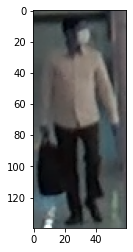

In [132]:
plt.imshow(cvimg)
plt.show()

In [133]:
image_crop(cvimg, cvimg)

TypeError: slice indices must be integers or None or have an __index__ method

In [104]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):

        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        if os.path.isfile(os.path.join(RESULT_DIR, 'total.pkl')):
            self.db = pd.read_pickle(os.path.join(RESULT_DIR, 'total.pkl'))
        else:
            self.db = self.data_loader()
            self.db = self.db.sample(frac=1).reset_index()
            self.db.to_pickle(os.path.join(RESULT_DIR, 'total.pkl'))
            
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
            
        mask_image_list = os.listdir(os.path.join(self.data_dir, 'Mask'))
        nomask_image_list = os.listdir(os.path.join(self.data_dir, 'NoMask'))
        
        
        
        
        mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
        nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
        mask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'Mask', x), mask_image_list))
        nomask_image_path = list(map(lambda x : os.path.join(self.data_dir, 'NoMask', x), nomask_image_list))

        # encoding label (Mask : 1, No Mask : 0)
        mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
        nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
        db = mask_df.append(nomask_df, ignore_index=True)
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])
        
        #origin_height, origin_width = image_copy.shape[:2]  # get image size
        crop_images = [] 


        for cv_img in cvimg:
            x,y,width, height = cv2.boundingRect(cv_img)
            
            crop_row1 = 0
            crop_row2 = width
            crop_col1 = 0
            crop_col2 = height//2
            
            crop = cv_img[crop_row1: crop_row2, crop_col1: crop_col2]
            crop_images.append(crop)        
            print(crop.shape)
            
            plt.imshow(crop)
            plt.show()

        
        plt.imshow(cv_img)
        plt.show()

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']



In [105]:
import timm

In [106]:
BACKBONE = 'tf_efficientnet_b5_ns'

In [107]:
from torch.nn import functional as F
from efficientnet_pytorch import EfficientNet

class MaskClassifier(nn.Module):
    def __init__(self):
        super(MaskClassifier, self).__init__()
        self.model = timm.create_model(BACKBONE, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

In [108]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            pred = F.softmax(pred)

            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)


In [109]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

In [110]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 24388 Val set samples: 2710


In [111]:
model = MaskClassifier().to(device)

In [112]:

# Save Initial Model
torch.save({'model':model.state_dict()}, os.path.join(RESULT_DIR, 'initial.pt'))

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=0.0001, last_epoch=-1)
criterion = nn.CrossEntropyLoss()
metric_fn = get_metric_fn

# Set system logger
system_logger = get_logger(name='train',file_path='train_log.log')

# Set trainer
trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)

# Set earlystopper
# early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE, verbose=True, logger=system_logger)

  0%|          | 0/20 [00:00<?, ?it/s]

(3, 3)


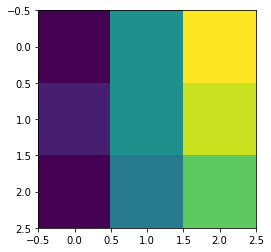

(3, 3)


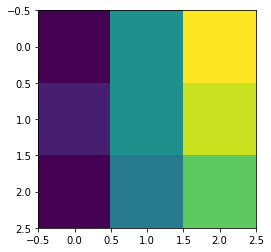

(3, 3)


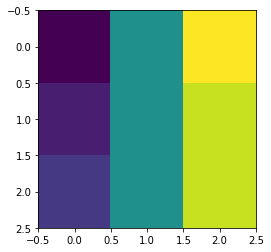

(3, 3)


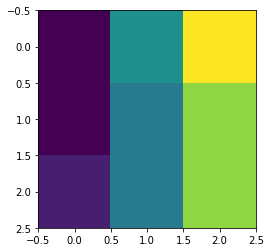

(3, 3)


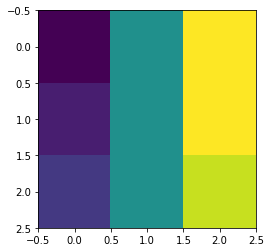

(3, 3)


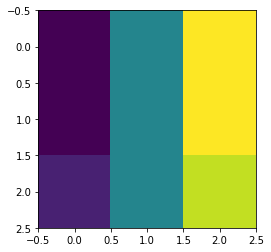

(3, 3)


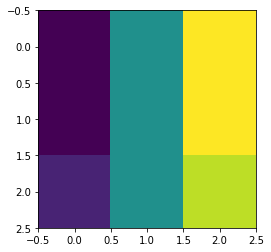

(3, 3)


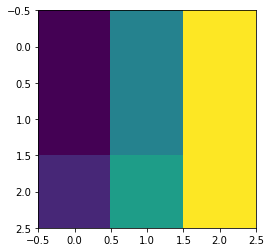

(3, 3)


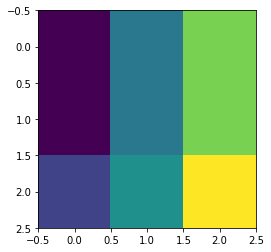

(3, 3)


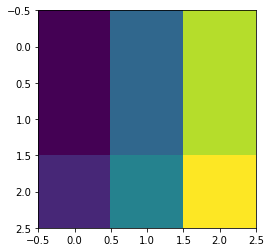

(3, 3)


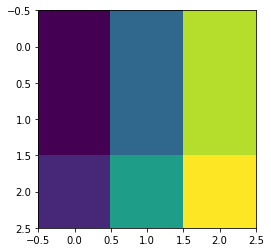

(3, 3)


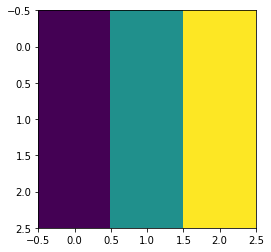

(3, 3)


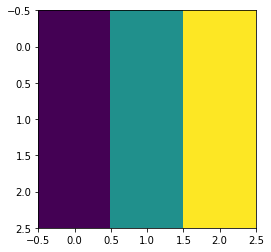

(3, 3)


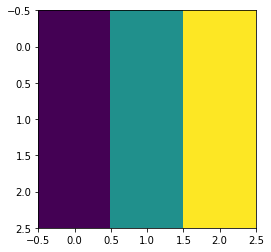

(3, 3)


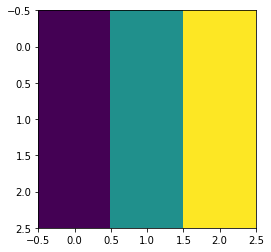

(3, 3)


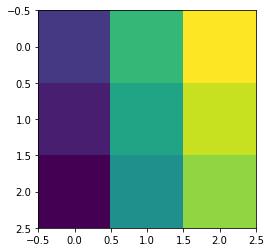

(3, 3)


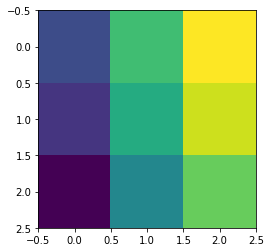

(3, 3)


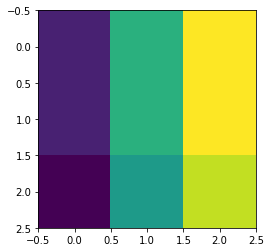

(3, 3)


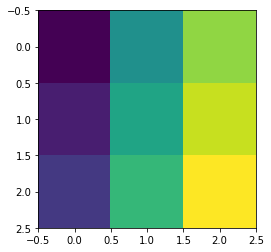

(3, 3)


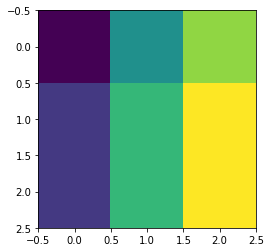

(3, 3)


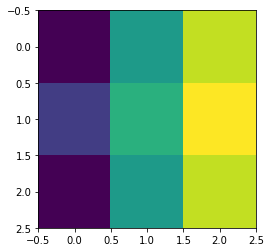

(3, 3)


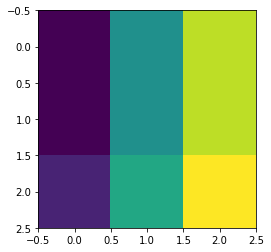

(3, 3)


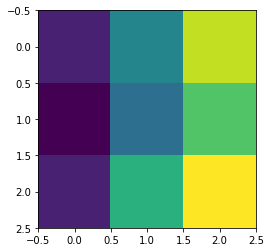

(3, 3)


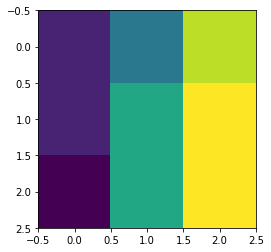

(3, 3)


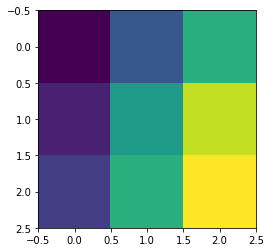

(3, 3)


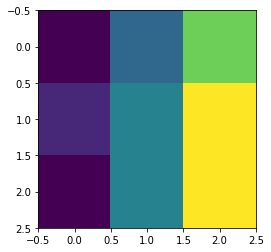

(3, 3)


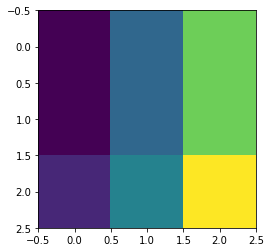

(3, 3)


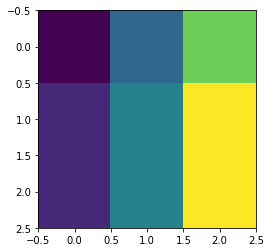

(3, 3)


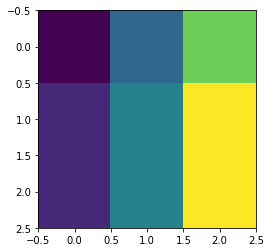

(3, 3)


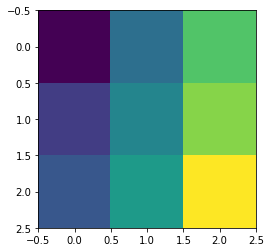

(3, 3)


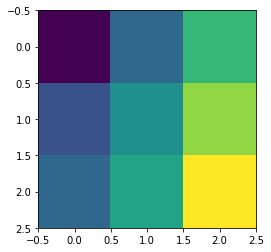

(3, 3)


  0%|          | 0/20 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [113]:
train_loss_history = []
train_acc_history = []

valid_loss_history = []
valid_acc_history = []

best_val_loss = None
best_val_acc = None

for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    train_loss_history.append(trainer.train_mean_loss)
    train_acc_history.append(trainer.train_score)
    
    valid_loss_history.append(trainer.val_mean_loss)
    valid_acc_history.append(trainer.validation_score)

    # don't use early stopper
    
    if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
        best_val_loss = trainer.val_mean_loss
        criterion = trainer.val_mean_loss
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))
        
best_val_acc = max(valid_acc_history)

In [ ]:
plt.plot(train_loss_history, label="train loss")
plt.plot(valid_loss_history, label="valid loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(train_acc_history, label="train acc")
plt.plot(valid_acc_history, label="valid acc")
plt.legend()
plt.show()

In [ ]:
TIME = datetime.now().strftime('%m%d%H%M%S')

save_dict = {'backbone':BACKBONE,
             'time':TIME,
             'best_val_loss':best_val_loss,
             'best_val_acc':best_val_acc,
             'test_score':None,
             'epochs':EPOCHS,
             'input_shape':INPUT_SHAPE,
             'augmentation':'ImageCrop(cv2)(180,180)',
             'optimizer':'Adam',
             'scheduler':'CosineAnnealingWarmRestarts',
             'attention_module':None,
             'learning_rate':LEARNING_RATE,
             'batch_size':BATCH_SIZE,
             'loss':'CrossEntropyLoss',
             'freeze':None,
             'others':'LabelSmoothing',
             'randomeseed':seed,
             'train_loss':train_loss_history,
             'train_acc':train_acc_history,
             'valid_loss':valid_loss_history,
             'valid_acc':valid_acc_history}


with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
    json.dump(save_dict, f)

In [ ]:
TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [92]:
TEST_DIR=os.path.join(ROOT_PATH, 'test')

# Load dataset & dataloader
test_dataset = TestDataset(data_dir=TEST_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


In [93]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_num_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in enumerate(test_dataloader):
        img = img.to(device)
        pred = F.softmax(model(img))
        file_num_lst.extend(list(file_num))
        prob_lst.extend(pred[:, 1].cpu().tolist())
        pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
df.sort_values(by=['file_name'], inplace=True)
df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)